In [1]:
import dino
import PIL
import sys 

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import PIL.Image as Image
import matplotlib.pyplot as plt
import heapq

from torchvision import transforms
from scipy.linalg import eigh
from deeptime.markov import pcca
from scipy.spatial.distance import cdist
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

sys.path.append('../')
from third_party.TokenCut.unsupervised_saliency_detection import utils, metric
from third_party.TokenCut.unsupervised_saliency_detection.object_discovery import detect_box


/home/vanessa/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
url = "https://dl.fbaipublicfiles.com/dino/dino_deitsmall8_300ep_pretrain/dino_deitsmall8_300ep_pretrain.pth"
cpu = False
feat_dim = 384
vit_arch = 'small'
vit_feat = 'k'
patch_size = 8
fixed_size = 480
backbone = dino.ViTFeat(url, feat_dim, vit_arch, vit_feat, patch_size)
backbone.eval()
if not cpu:
    backbone.cuda()
    
ToTensor = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(
                                (0.485, 0.456, 0.406),
                                (0.229, 0.224, 0.225)),])

Loading weight from https://dl.fbaipublicfiles.com/dino/dino_deitsmall8_300ep_pretrain/dino_deitsmall8_300ep_pretrain.pth


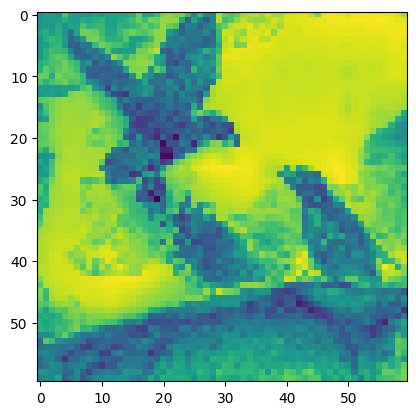

In [3]:
img_path = 'imgs/demo2.jpg'
I = Image.open(img_path).convert('RGB')
bipartitions, eigvecs = [], []

I_new = I.resize((int(fixed_size), int(fixed_size)), PIL.Image.LANCZOS)
I_resize, w, h, feat_w, feat_h = utils.resize_pil(I_new, patch_size)

tensor = ToTensor(I_resize).unsqueeze(0)
if not cpu: tensor = tensor.cuda()
feat = backbone(tensor)[0]
plt.imshow(feat[10].reshape(60,60).cpu())

In [46]:
pairwise_distances = cdist(feat.cpu().T, feat.cpu().T, metric='euclidean')

In [10]:
pairwise_distances

array([[ 0.        ,  2.06306311,  3.9267449 , ..., 10.90366553,
        11.82234911, 12.43742235],
       [ 2.06306311,  0.        ,  2.79617433, ..., 10.62803975,
        11.9159282 , 12.45205559],
       [ 3.9267449 ,  2.79617433,  0.        , ..., 11.05555416,
        12.08894232, 12.77404083],
       ...,
       [10.90366553, 10.62803975, 11.05555416, ...,  0.        ,
         7.05306474,  8.3020115 ],
       [11.82234911, 11.9159282 , 12.08894232, ...,  7.05306474,
         0.        ,  6.08135446],
       [12.43742235, 12.45205559, 12.77404083, ...,  8.3020115 ,
         6.08135446,  0.        ]])

In [48]:
def compute_effective_distances(distances):
    mst = minimum_spanning_tree(distances).toarray()
    mst = np.maximum(mst, mst.T)  # Symmetrize the MST
    n = distances.shape[0]
    # Compute effective distances by traversing the MST
    effective_distances = np.full((n, n), np.inf)
    for i in range(n):
        queue = [(0, i, i)]
        effective_distances[i, i] = 0
        while queue:
            dist, node, start = heapq.heappop(queue)
            for neighbor in range(n):
                if mst[node, neighbor] > 0:
                    new_dist = max(dist, mst[node, neighbor])
                    if new_dist < effective_distances[start, neighbor]:
                        effective_distances[start, neighbor] = new_dist
                        heapq.heappush(queue, (new_dist, neighbor, start))
    return effective_distances


effective_distances = compute_effective_distances(pairwise_distances)

KeyboardInterrupt: 

In [7]:
def get_masked_affinity_matrix(painting, feats, mask, ps):
    # mask out affinity matrix based on the painting matrix 
    dim, num_patch = feats.size()[0], feats.size()[1]
    painting = painting + mask.unsqueeze(0)
    painting[painting > 0] = 1
    painting[painting <= 0] = 0
    feats = feats.clone().view(dim, ps, ps)
    feats = ((1 - painting) * feats).view(dim, num_patch)
    return feats, painting

def get_affinity_matrix(feats, tau, eps=1e-5):
    # get affinity matrix via measuring patch-wise cosine similarity
    feats = F.normalize(feats, p=2, dim=0)
    A = (feats.transpose(0,1) @ feats).cpu().numpy()
    # convert the affinity matrix to a binary one.
    A = A > tau
    A = np.where(A.astype(float) == 0, eps, A)
    d_i = np.sum(A, axis=1)
    D = np.diag(d_i)
    return A, D

def second_smallest_eigenvector(A, D):
    # get the second smallest eigenvector from affinity matrix
    _, eigenvectors = eigh(D-A, D, subset_by_index=[1,2])
    eigenvec = np.copy(eigenvectors[:, 0])
    second_smallest_vec = eigenvectors[:, 0]
    return eigenvec, second_smallest_vec

def get_salient_areas(second_smallest_vec):
    # get the area corresponding to salient objects.
    avg = np.sum(second_smallest_vec) / len(second_smallest_vec)
    bipartition = second_smallest_vec > avg
    return bipartition

def check_num_fg_corners(bipartition, dims):
    # check number of corners belonging to the foreground
    bipartition_ = bipartition.reshape(dims)
    top_l, top_r, bottom_l, bottom_r = bipartition_[0][0], bipartition_[0][-1], bipartition_[-1][0], bipartition_[-1][-1]
    nc = int(top_l) + int(top_r) + int(bottom_l) + int(bottom_r)
    return nc

In [24]:
def maskcut(img_path, backbone,patch_size, tau, N=1, fixed_size=480, cpu=False) :
    I = Image.open(img_path).convert('RGB')
    bipartitions, eigvecs = [], []

    I_new = I.resize((int(fixed_size), int(fixed_size)), PIL.Image.LANCZOS)
    I_resize, w, h, feat_w, feat_h = utils.resize_pil(I_new, patch_size)

    tensor = ToTensor(I_resize).unsqueeze(0)
    if not cpu: tensor = tensor.cuda()
    feat = backbone(tensor)[0]

    _, bipartition, eigvec = maskcut_forward(feat, [feat_h, feat_w], [patch_size, patch_size], [h,w], tau, N=N, cpu=cpu)

    bipartitions += bipartition
    eigvecs += eigvec

    return bipartitions, eigvecs, I_new

def maskcut_forward(feats, dims, scales, init_image_size, tau=0, N=3, cpu=False):
    """
    Implementation of MaskCut.
    Inputs
      feats: the pixel/patche features of an image
      dims: dimension of the map from which the features are used
      scales: from image to map scale
      init_image_size: size of the image
      tau: thresold for graph construction
      N: number of pseudo-masks per image.
    """
    bipartitions = []
    eigvecs = []

    for i in range(N):
        print(f'---------{i}th step--------')
        if i == 0:
            painting = torch.from_numpy(np.zeros(dims))
            if not cpu: painting = painting.cuda()
        else:
            feats, painting = get_masked_affinity_matrix(painting, feats, current_mask, ps)

        # construct the affinity matrix
        A, D = get_affinity_matrix(feats, tau)
        # get the second smallest eigenvector
        eigenvec, second_smallest_vec = second_smallest_eigenvector(A, D)
        plt.imshow(second_smallest_vec.reshape(60, 60))
        plt.show()
        # get salient area
        bipartition = get_salient_areas(second_smallest_vec)
        plt.imshow(bipartition.reshape(60,60))
        plt.show()

        # check if we should reverse the partition based on:
        # 1) peak of the 2nd smallest eigvec 2) object centric bias
        seed = np.argmax(np.abs(second_smallest_vec))
        nc = check_num_fg_corners(bipartition, dims)
        if nc >= 3:
            reverse = True
        else:
            reverse = bipartition[seed] != 1

        if reverse:
            # reverse bipartition, eigenvector and get new seed
            eigenvec = eigenvec * -1
            bipartition = np.logical_not(bipartition)
            seed = np.argmax(eigenvec)
        else:
            seed = np.argmax(second_smallest_vec)

        # get pxiels corresponding to the seed
        bipartition = bipartition.reshape(dims).astype(float)
        _, _, _, cc = detect_box(bipartition, seed, dims, scales=scales, initial_im_size=init_image_size)
        pseudo_mask = np.zeros(dims)
        pseudo_mask[cc[0],cc[1]] = 1
        pseudo_mask = torch.from_numpy(pseudo_mask)
        plt.imshow(pseudo_mask)
        plt.show()
        if not cpu: pseudo_mask = pseudo_mask.to('cuda')
        ps = pseudo_mask.shape[0]

        # check if the extra mask is heavily overlapped with the previous one or is too small.
        if i >= 1:
            ratio = torch.sum(pseudo_mask) / pseudo_mask.size()[0] / pseudo_mask.size()[1]
            if metric.IoU(current_mask, pseudo_mask) > 0.5 or ratio <= 0.01:
                pseudo_mask = np.zeros(dims)
                pseudo_mask = torch.from_numpy(pseudo_mask)
                if not cpu: pseudo_mask = pseudo_mask.to('cuda')
        current_mask = pseudo_mask

        # mask out foreground areas in previous stages
        masked_out = 0 if len(bipartitions) == 0 else np.sum(bipartitions, axis=0)
        bipartition = F.interpolate(pseudo_mask.unsqueeze(0).unsqueeze(0), size=init_image_size, mode='nearest').squeeze()
        bipartition_masked = bipartition.cpu().numpy() - masked_out
        bipartition_masked[bipartition_masked <= 0] = 0
        bipartitions.append(bipartition_masked)

        # unsample the eigenvec
        eigvec = second_smallest_vec.reshape(dims)
        eigvec = torch.from_numpy(eigvec)
        if not cpu: eigvec = eigvec.to('cuda')
        eigvec = F.interpolate(eigvec.unsqueeze(0).unsqueeze(0), size=init_image_size, mode='nearest').squeeze()
        eigvecs.append(eigvec.cpu().numpy())

    return seed, bipartitions, eigvecs

---------0th step--------


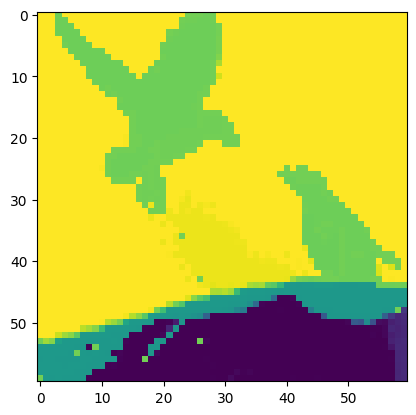

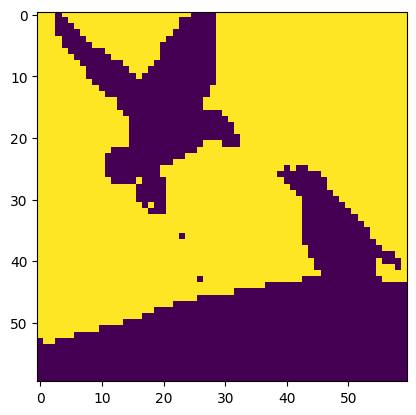

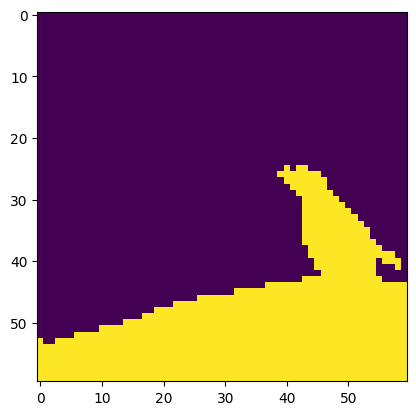

---------1th step--------


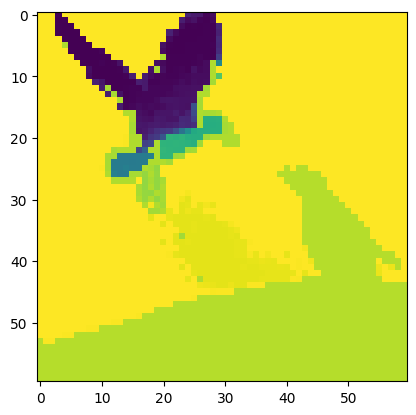

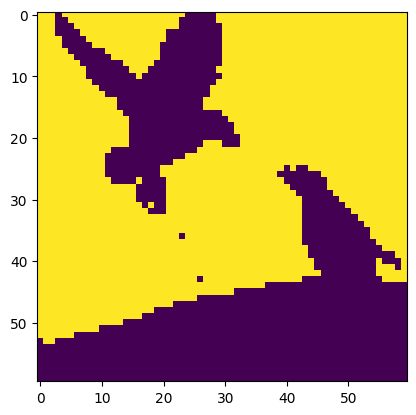

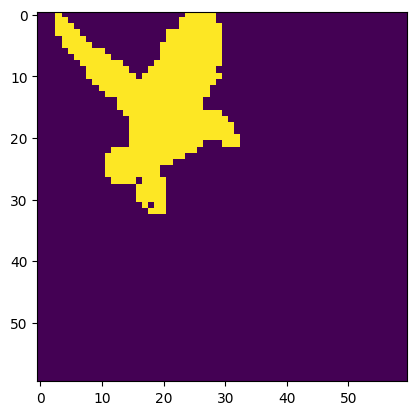

---------2th step--------


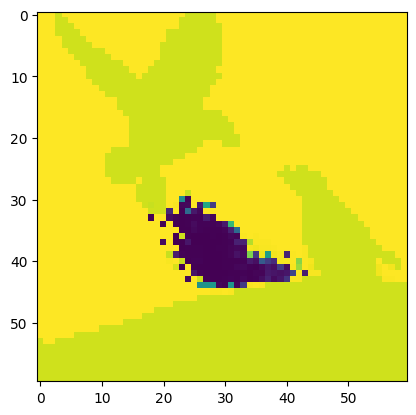

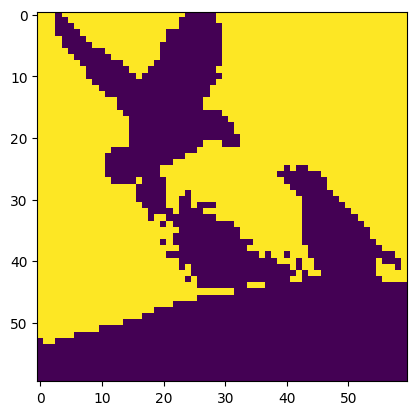

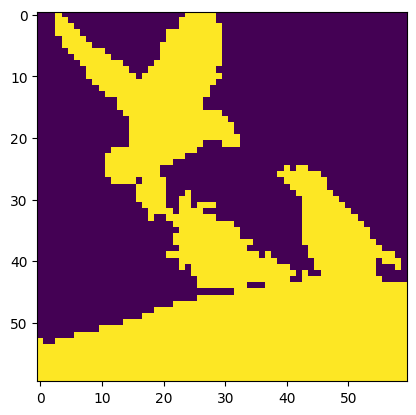

In [26]:
img_path = 'imgs/demo2.jpg'
tau = 0.8 #0.15
fixed_size = 480
N = 3

bipartitions, _, I_new = maskcut(img_path, backbone, patch_size, tau, \
        N=N, fixed_size=fixed_size, cpu=cpu)

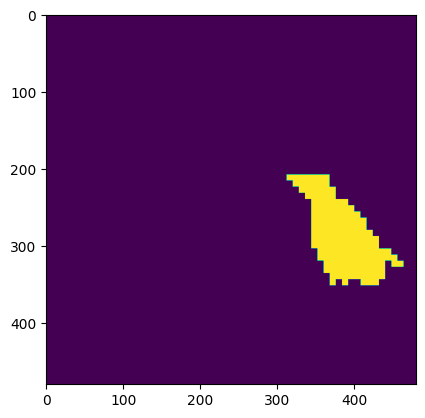

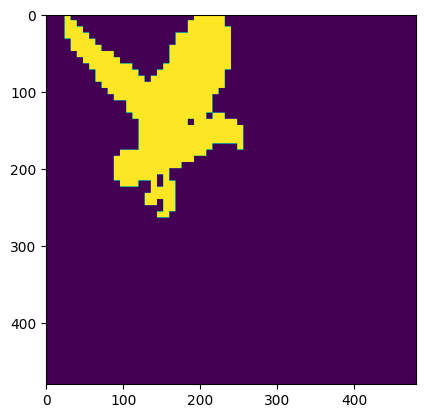

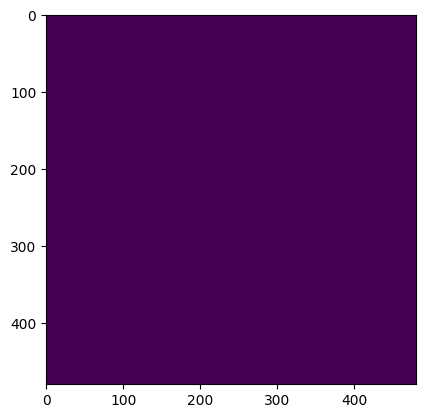

In [19]:
for bipartition in bipartitions:
    plt.imshow(bipartition)
    plt.show()

In [52]:
ToTensor = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(
                                (0.485, 0.456, 0.406),
                                (0.229, 0.224, 0.225)),])

def get_affinity_matrix(feats, tau, eps=1e-5):
    # get affinity matrix via measuring patch-wise cosine similarity
    feats = F.normalize(feats, p=2, dim=0)
    A = (feats.transpose(0,1) @ feats).cpu().numpy()
    # convert the affinity matrix to a binary one.
    A = A > tau
    A = np.where(A.astype(float) == 0, eps, A)
    d_i = np.sum(A, axis=1)
    D = np.diag(d_i)
    return A, D

def compute_effective_distances(distances):
    mst = minimum_spanning_tree(distances).toarray()
    mst = np.maximum(mst, mst.T)  # Symmetrize the MST
    n = distances.shape[0]
    # Compute effective distances by traversing the MST
    effective_distances = np.full((n, n), np.inf)
    for i in range(n):
        queue = [(0, i, i)]
        effective_distances[i, i] = 0
        while queue:
            dist, node, start = heapq.heappop(queue)
            for neighbor in range(n):
                if mst[node, neighbor] > 0:
                    new_dist = max(dist, mst[node, neighbor])
                    if new_dist < effective_distances[start, neighbor]:
                        effective_distances[start, neighbor] = new_dist
                        heapq.heappush(queue, (new_dist, neighbor, start))
    return effective_distances

def get_pcca_affinity_matrix(feats, tau=3):
    feats = F.normalize(feats, p=2, dim=0)
    A = (feats.transpose(0, 1) @ feats).cpu().numpy()
    A = np.exp(A * tau)
    A = A.astype(np.double)
    T = A/np.sum(A, axis=1, keepdims=True)
    return T

def get_pcca_euclidean_affinity_matrix(feats, tau=3): 
    feats = F.normalize(feats, p=2, dim=0)
    feats_np = feats.cpu().numpy()
    pairwise_distances = cdist(feats_np.T, feats_np.T, metric='euclidean')
    # effective_distances = compute_effective_distances(pairwise_distances)
    beta = 20
    affinities = np.exp(-beta * (pairwise_distances ** 2))
    affinities += 1e-5 
    affinities /= np.sum(affinities, axis=1, keepdims=True)
    return affinities

def maskcut_pcca(img_path, backbone, patch_size, tau, N=1, fixed_size=480, cpu=False) :
    I = Image.open(img_path).convert('RGB')

    I_new = I.resize((int(fixed_size), int(fixed_size)), PIL.Image.LANCZOS)
    I_resize, w, h, feat_w, feat_h = utils.resize_pil(I_new, patch_size)

    tensor = ToTensor(I_resize).unsqueeze(0)
    if not cpu: tensor = tensor.cuda()
    feat = backbone(tensor)[0]

    maskcut_forward_pcca(feat, [feat_h, feat_w], [patch_size, patch_size], [h,w], N, tau, cpu=cpu)


def maskcut_forward_pcca(feats, dims, scales, init_image_size, N=3, tau=0, cpu=False):
    """
    Implementation of MaskCut.
    Inputs
      feats: the pixel/patche features of an image
      dims: dimension of the map from which the features are used
      scales: from image to map scale
      init_image_size: size of the image
      tau: thresold for graph construction
      N: number of pseudo-masks per image.
    """
    bipartitions = []
    eigvecs = []

    # construct the affinity matrix
    # A, D = get_affinity_matrix(feats, tau)
    T = get_pcca_euclidean_affinity_matrix(feats, tau)
    print(T.shape)
    
    n_components, labels = connected_components(csgraph=csr_matrix(T), directed=False)
    print(f"Number of connected components: {n_components}")
    if n_components > 1:
        print("Warning: The affinity matrix has disconnected components!")
    # get the second smallest eigenvector
    pcca_m = pcca(T, N)
    bipartitions = pcca_m.memberships.T
    print(bipartitions.shape)
    bipartitions = bipartitions.reshape(N,60,60) #16,24
    crisp_clusters = np.argmax(bipartitions, axis=0)
    print(np.unique(crisp_clusters))
    plt.imshow(crisp_clusters)
    plt.show()
    
    for bipartition in bipartitions:
        plt.imshow(bipartition.reshape(60,60)) #16,24
        plt.show()
    # eigenvec, second_smallest_vec = second_smallest_eigenvector(A, D)
    # plt.imshow(second_smallest_vec.reshape(60, 60))
    # plt.show()
    # # get salient area
    # bipartition = get_salient_areas(second_smallest_vec)
    # plt.imshow(bipartition.reshape(60,60))
    # plt.show()

(3600, 3600)
Number of connected components: 1
(5, 3600)
[0 1 2 3 4]


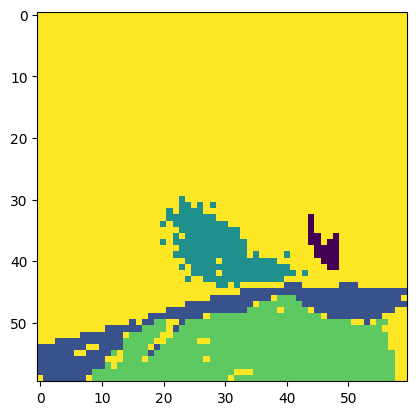

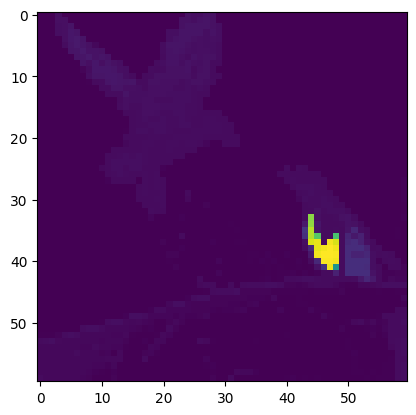

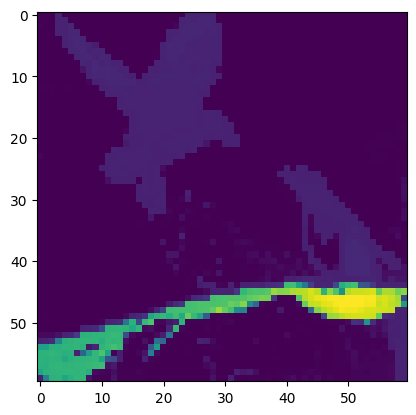

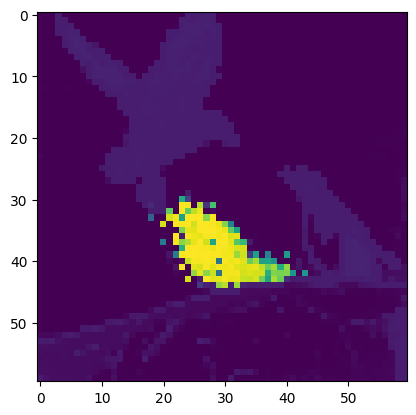

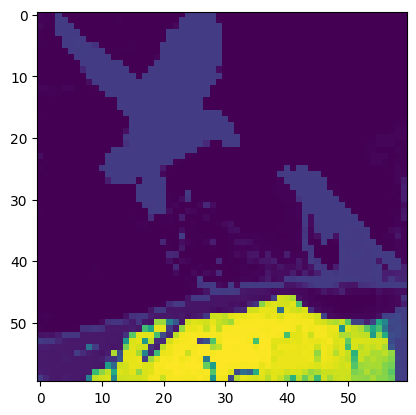

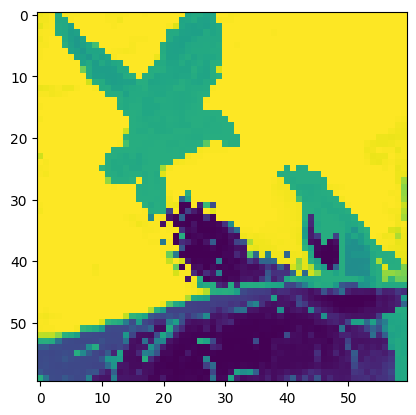

In [53]:
img_path = 'imgs/demo2.jpg'
tau = 2
fixed_size = 480
N = 5

maskcut_pcca(img_path, backbone, patch_size, tau, \
        N=N, fixed_size=fixed_size, cpu=cpu)

In [74]:
import torch
import torch.nn as nn
import torch.optim as optim

class MembershipProbabilityLayer(nn.Module):
    def __init__(self, original_dim, reduced_dim):
        super().__init__()
        self.membership_params = nn.Parameter(torch.randn(original_dim, reduced_dim))
    
    def forward(self, affinity_matrix):
        affinity_matrix = torch.exp(affinity_matrix * 3)
        membership_probs = torch.softmax(self.membership_params, dim=1)
        A = membership_probs.T @ affinity_matrix @ membership_probs
        T = A/torch.sum(A, axis=1, keepdims=True)
        return membership_probs, T
    
    def custom_loss(self, sigma):
        return -torch.trace(sigma)

def train_membership_layer(layer, affinity_matrix, original_dim, reduced_dim, epochs=10000):
    optimizer = torch.optim.Adam(
        layer.parameters(),
        lr=0.001,
    )
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        layer.train()
        membership_probs, sigma = layer(affinity_matrix)
        loss = layer.custom_loss(sigma)
        loss.backward()
        optimizer.step()        
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    

device = "cuda"

original_dim = 3600
reduced_dim = 5

I = Image.open(img_path).convert('RGB')
I_new = I.resize((int(fixed_size), int(fixed_size)), PIL.Image.LANCZOS)
I_resize, w, h, feat_w, feat_h = utils.resize_pil(I_new, patch_size)

layer = MembershipProbabilityLayer(original_dim, reduced_dim).to(device)
tensor = ToTensor(I_resize).unsqueeze(0)
if not cpu: tensor = tensor.cuda()
feat = backbone(tensor)[0]
feats = F.normalize(feat, p=2, dim=0)
A = (feats.transpose(0, 1) @ feats).cpu().numpy()
T = A/np.sum(A, axis=1, keepdims=True)

# Train the layer
train_membership_layer(layer, torch.from_numpy(A).to(device).float(), original_dim, reduced_dim, epochs=50000)

Epoch 0, Loss: -1.0003503561019897
Epoch 1000, Loss: -1.2562670707702637
Epoch 2000, Loss: -1.5358572006225586
Epoch 3000, Loss: -1.6684602499008179
Epoch 4000, Loss: -1.716432809829712
Epoch 5000, Loss: -1.735926628112793
Epoch 6000, Loss: -1.7445685863494873
Epoch 7000, Loss: -1.7491087913513184
Epoch 8000, Loss: -1.7519471645355225
Epoch 9000, Loss: -1.7536488771438599
Epoch 10000, Loss: -1.754734992980957
Epoch 11000, Loss: -1.7555029392242432
Epoch 12000, Loss: -1.7559581995010376
Epoch 13000, Loss: -1.7562241554260254
Epoch 14000, Loss: -1.7564799785614014
Epoch 15000, Loss: -1.756702184677124
Epoch 16000, Loss: -1.7568528652191162
Epoch 17000, Loss: -1.7569553852081299
Epoch 18000, Loss: -1.7570290565490723
Epoch 19000, Loss: -1.7570875883102417
Epoch 20000, Loss: -1.7571158409118652
Epoch 21000, Loss: -1.7571630477905273
Epoch 22000, Loss: -1.7571899890899658
Epoch 23000, Loss: -1.7572052478790283
Epoch 24000, Loss: -1.7572424411773682
Epoch 25000, Loss: -1.757260799407959
Epoc

In [75]:
layer.membership_params

Parameter containing:
tensor([[-5.2612, 10.4609, -6.0145, -4.4245, -4.1280],
        [-5.8069, 10.5104, -5.8770, -4.6248, -5.1698],
        [-5.2733, 11.3570, -5.8349, -4.2000, -3.3098],
        ...,
        [-4.9146, 10.4157, -3.6143, -3.2704, -4.7872],
        [-4.4111, -3.8989,  9.2380, -5.1963, -5.4236],
        [-2.4819, 10.0263, -5.3428, -5.0180, -4.6570]], device='cuda:0',
       requires_grad=True)

In [76]:
membership_probs = torch.softmax(layer.membership_params, dim=1).detach().cpu()

In [ ]:
- compare eignevectors of our T_C with the one of PCCA++
- membership from PCCA++ and use them as initialized

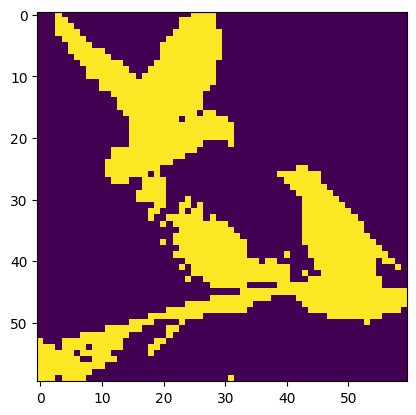

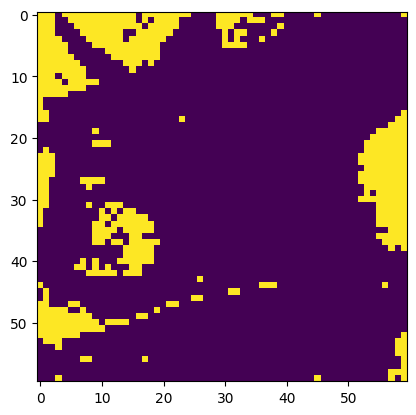

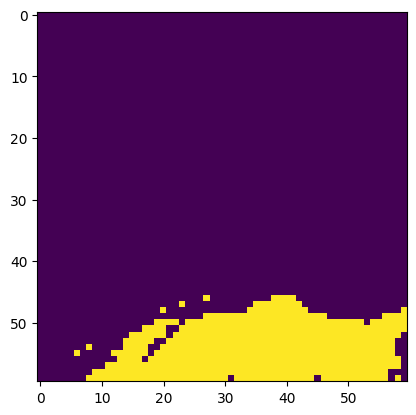

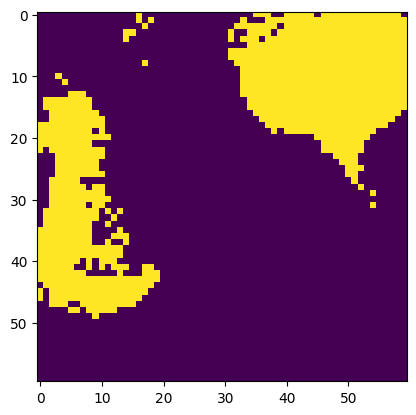

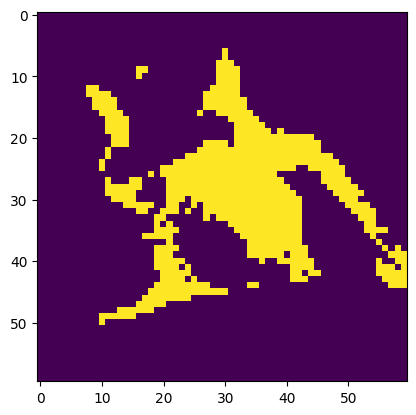

In [77]:
for i in range(5):
    plt.imshow(membership_probs.T[i].reshape(60,60))
    plt.show()

In [15]:
weights = layer.membership_params.detach().cpu().numpy()


In [85]:
weights.shape

(3600, 360)

In [30]:
import torch

def verify_matrix_properties(A, P):
    # Verify A row sums
    A_row_sums = A.sum(dim=0)
    print("A row sums:", torch.allclose(A_row_sums, torch.ones(A.shape[0])))
    
    # Verify P column sums
    P_col_sums = P.sum(dim=0)
    print("P column sums:", torch.allclose(P_col_sums, torch.ones(P.shape[1])))
    
    # Compute Sigma
    Sigma = P.T @ A @ P
    
    # Verify Sigma total sum
    print("Sigma total sum:", Sigma.sum().item())

# Example setup
original_dim = 3600
reduced_dim = 360

A = torch.randn(original_dim, original_dim)
A = (A + A.T) / 2  # Symmetric
A = A / A.sum(dim=1, keepdim=True)  # Normalize rows

P = torch.softmax(torch.randn(original_dim, reduced_dim), dim=0)

verify_matrix_properties(A, P)

A row sums: False
P column sums: True
Sigma total sum: 38.22983169555664
